# Figure 9

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign,N_visc
from mpi4py import MPI
from params import nz
from petsc4py import PETSc
from solvers import initialize,solve_pde, time_stepping, heave_plastic
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from post_process import interp
from scipy.interpolate import interp1d

In [3]:
# generate mesh
N_f = 2  # effective stress at base of fringe 
z_l = 4.6
z_b = 1e-3
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])
gamma = 16
const_phi = False

# define initial condition N that satisfies the
# elliptic problem: D(phi,S) N']' = F(phi,S)    
# which is valid for rigid solutions (dN/dt + v_i dN/dz = 0)
initial = initialize(domain,N_f,gamma,const_phi,eps_min=1e-10)

In [5]:
# set ice velocity (pulling speed) and timesteps 
v_i = 0.012
N_c = 0.0
timesteps = np.linspace(0,4e3,4000)

# solve the time-dependent problem
N,heave,visc, z, new_lens, converged = time_stepping(domain,initial,N_f,N_c,gamma,const_phi,v_i,timesteps,eps=1e-10)

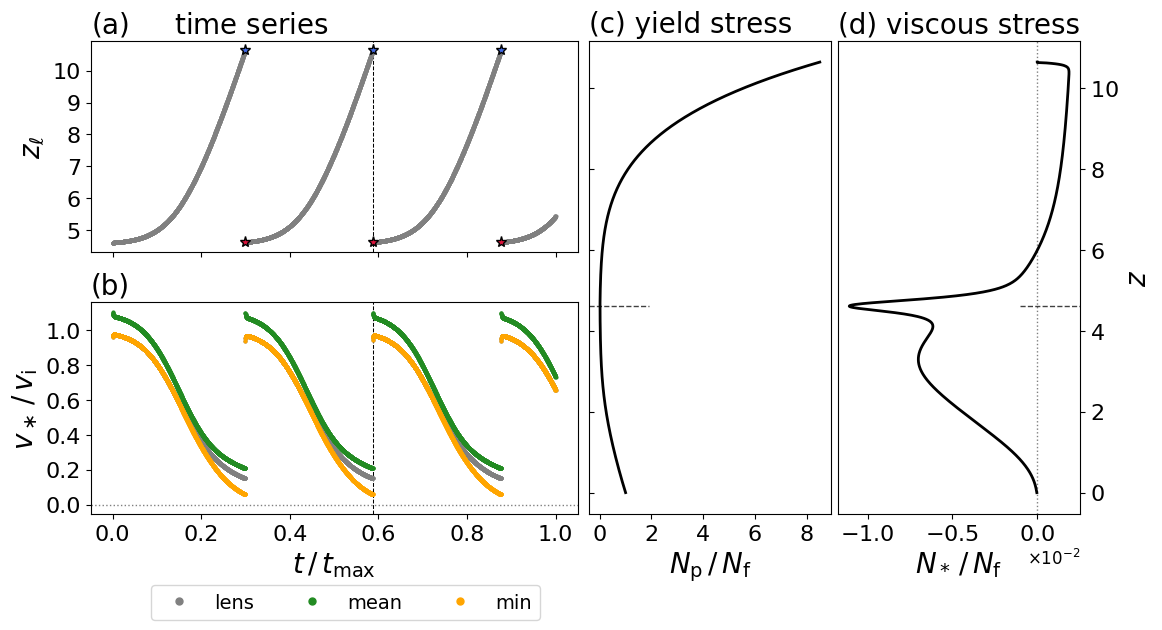

In [6]:
# plot position of active ice lens over time and heave rate
phi_f = Phi(N_f,log=np.log)
z_l = np.max(z,axis=1)
old_lens = np.roll(new_lens,-1)
heave_lens = heave[:,-1]/v_i
heave_mean = np.mean(heave,axis=1)/v_i
heave_min = np.min(heave,axis=1)/v_i

l = np.where(new_lens==1)[0][1]



plt.figure(figsize=(11,6))
plt.subplot(221)
plt.title(r'(a) $\quad$ time series',fontsize=20,loc='left')
plt.axvline(timesteps[l]/timesteps.max(),color='k',linestyle='--',linewidth=0.75)
plt.plot(timesteps/timesteps.max(),z_l,'o',markersize=2,color='gray')
plt.plot(timesteps[old_lens==1]/timesteps.max(),z_l[old_lens==1],'*',markersize=8,markeredgecolor='k',color='royalblue',label=r'$z_\mathrm{m}$')
plt.plot(timesteps[new_lens==1]/timesteps.max(),z_l[new_lens==1],'*',markersize=8,markeredgecolor='k',color='crimson',label=r'$z_\mathrm{n}$')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=20)
# plt.ylim(0,8)

plt.gca().xaxis.set_ticklabels([])

plt.subplot(223)
plt.axvline(timesteps[l]/timesteps.max(),color='k',linestyle='--',linewidth=0.75)
plt.title(r'(b)',fontsize=20,loc='left')
plt.plot(timesteps[heave_lens!=0]/timesteps.max(),heave_lens[heave_lens!=0],'o',markersize=2,color='gray',label=r'lens')
plt.plot(timesteps[heave_mean!=0]/timesteps.max(),heave_mean[heave_mean!=0],'o',markersize=2,color='forestgreen',label=r'mean')
plt.plot(timesteps[heave_min!=0]/timesteps.max(),heave_min[heave_min!=0],'o',markersize=2,color='orange',label=r'min')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(0,linestyle=':',color='k',linewidth=1,alpha=0.5)
plt.ylabel(r'${v}_\ast\,/\,v_\mathrm{i}$',fontsize=20)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.tight_layout()
lgnd = plt.legend(fontsize=14,ncol=3,loc=(0.125,-0.5))
lgnd.legendHandles[0].set_markersize(5)
lgnd.legendHandles[1].set_markersize(5)
lgnd.legendHandles[2].set_markersize(5)

plt.subplot(143)
plt.title(r'(c) yield stress',fontsize=20,loc='left')
plt.axhline(z[l,-1],xmax=0.25,linestyle='--',color='black',linewidth=1,alpha=0.75)
plt.plot(N[l-1,:]/N_f,z[l-1,:],color='black',linewidth=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().yaxis.set_ticklabels([])
plt.gca().tick_params(axis="y",direction="in")
plt.xlabel(r'$N_\mathrm{p}\,/\,N_\mathrm{f}$',fontsize=20)
# lgnd = plt.legend(fontsize=14,loc='lower right',ncol=1)
# lgnd.legendHandles[0].set_markersize(8)
# lgnd.legendHandles[1].set_markersize(8)


plt.subplot(144)
plt.title(r'(d) viscous stress',fontsize=20,loc='left')
plt.axvline(0,linestyle=':',color='k',linewidth=1,alpha=0.5)
plt.axhline(z[l,-1],xmin=0.75,linestyle='--',color='black',linewidth=1,alpha=0.75)
plt.plot(visc[l-1,:]/N_f,z[l-1,:],color='black',linewidth=2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.gca().ticklabel_format(useMathText=True)
plt.gca().xaxis.get_offset_text().set_fontsize(12)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z$',fontsize=20)
plt.xlabel(r'$N_* \,/\,N_\mathrm{f} $',fontsize=20)
plt.savefig('Fig9',bbox_inches='tight')
plt.show()
plt.close()